# 21 vs 61 Period Moving Average Reversion Strategy

In [1]:
#!pip install oandapyV20

In [2]:
#!pip install zulu

In [3]:
#!pip install mpl_finance

In [1]:
import numpy as np
import pandas as pd
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import datetime
import zulu
import os

pd.set_option('display.float_format', '{:.4f}'.format)

In [2]:
ID = '101-004-9949998-001'
token = '4900a27fe17ab573d490ce234465329f-6633f44d08bf25b48ceaacd2c7917674'

In [3]:
client = oandapyV20.API(access_token=token)

# 21 Period Moving Average Reversion strategy on EURUSD

In [6]:
# Loop to create the dataset

Date = pd.Series(datetime.datetime(2010, 4, 1, 0, 0, 0))
eurusd = pd.DataFrame()


while Date.iloc[-1].year != 2020 or Date.iloc[-1].month != 4:
    
    last = Date.iloc[-1]
    inizio = last + datetime.timedelta(minutes=5)
    inizio = zulu.create(inizio.year, inizio.month, inizio.day, inizio.hour, inizio.minute)
    inizio = inizio.isoformat('T')+'Z'
    inizio = str(inizio[:-8] + 'Z')

    params = {
            "from": inizio,
            "granularity": "M5"}

    r = instruments.InstrumentsCandles(instrument="EUR_USD",
                                       params=params)

    rv = client.request(r)

    newDat = []
    for oo in r.response['candles']:
        newDat.append([oo['time'], oo['mid']['o'], oo['mid']['h'], oo['mid']['l'], oo['mid']['c']])
    
    newEurusd = pd.DataFrame(newDat)
    newEurusd.columns = ['Time', 'Open', 'High', 'Low', 'Close']
    newEurusd["Time"] = pd.to_datetime(newEurusd['Time'])
    Date = Date.append(newEurusd['Time'])
    newEurusd['Time'] = newEurusd['Time'].apply(mpl_dates.date2num)
    newEurusd = newEurusd.astype(float)
    eurusd = eurusd.append(newEurusd)
    
#Adjusting so that eurusd and Date match
Date = Date.drop(index=0)
eurusd = eurusd.drop(index=0)

eurusd.index = range(eurusd.shape[0])
Date.index = range(eurusd.shape[0])

eurusd.head()

,Time,Open,High,Low,Close
0,733863.0111,1.3542,1.3544,1.3541,1.3544
1,733863.0118,1.3545,1.3545,1.3541,1.3541
2,733863.0125,1.3541,1.3542,1.3540,1.3540
3,733863.0132,1.3540,1.3540,1.3539,1.3539
4,733863.0139,1.3539,1.3545,1.3539,1.3545


In [7]:
#First and Last Day of the dataset
print(eurusd.shape)
print(Date.iloc[0])
print(Date.iloc[-1])
print(eurusd.head(5))

(3485016, 5)
2010-04-01 00:16:00
2020-04-01 05:39:00
         Time   Open   High    Low  Close
0 733863.0111 1.3542 1.3544 1.3541 1.3544
1 733863.0118 1.3545 1.3545 1.3541 1.3541
2 733863.0125 1.3541 1.3542 1.3540 1.3540
3 733863.0132 1.3540 1.3540 1.3539 1.3539
4 733863.0139 1.3539 1.3545 1.3539 1.3545


In [5]:
#Export and Import the dataset
#eurusd.to_csv(os.getcwd()+'\\eurusd5min.csv')
eurusd = pd.read_csv(os.getcwd()+'\\eurusd5min.csv', index_col=0)

#Date.to_csv(os.getcwd()+'\\eurusd5minTime.csv')
Date = pd.read_csv(os.getcwd()+'\\eurusd5minTime.csv', header=None, index_col=0)
Date = Date.iloc[:,0]

### Definition of the Moving Average

In [2]:
def CrossMovingAverage(rates, fast_period, slow_period):
    fastMA=[]
    slowMA=[]
    
    fastMA = eurusd['Close'].rolling(fast_period).mean()
    slowMA= eurusd['Close'].rolling(slow_period).mean()
        
    return slow_period, fastMA, slowMA

In [44]:
slow_period, fastMA, slowMA = CrossMovingAverage(eurusd, 8, 21)

eurusd["fastMA"] = fastMA
eurusd["slowMA"] = slowMA

eurusd = eurusd.iloc[21:]
eurusd.index = range(eurusd.shape[0])

data = {'time':Date, 'close':eurusd["Close"],'fastMA':fastMA, 'slowMA':slowMA}

flag = pd.DataFrame(data)

flag.index = range(flag.shape[0])
flag = flag.drop(flag.index[0:21])
flag.index = range(flag.shape[0])

In [45]:
plt.style.use('ggplot')

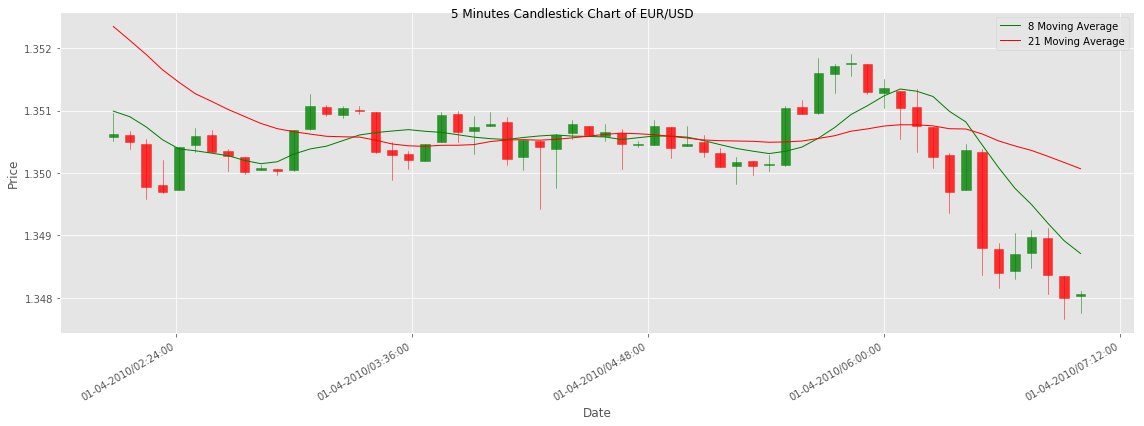

In [46]:
# Creating Subplots
fig, ax = plt.subplots(figsize = (16,6))

candlestick_ohlc(ax, eurusd.iloc[range(60), range(5)].values, width=0.002, colorup='green', colordown='red', alpha=0.8)
ax.plot(eurusd['Time'][:60], eurusd["fastMA"][:60], color = 'green', linewidth = 1, label='8 Moving Average')
ax.plot(eurusd['Time'][:60], eurusd["slowMA"][:60], color = 'red', linewidth = 1, label='21 Moving Average')
leg = ax.legend();

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('5 Minutes Candlestick Chart of EUR/USD')

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y/%H:%M:%S')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()

plt.show()

In [47]:
print(eurusd.shape)
print(flag.shape)

(745984, 7)
(745984, 4)


## Strategy - buy or sell if the price is far from the 21 Moving Average

In [48]:
# Creating boolean values if the below conditions are true
flag["distance"] = np.where(flag["close"] >= flag["slowMA"], (flag["close"]-flag["slowMA"])*10000, (flag["close"]-flag["slowMA"])*10000 )

In [49]:
flag.head(10)

,time,close,fastMA,slowMA,distance
0,2010-04-01 02:05:00,1.3506,1.3510,1.3523,-16.9714
1,2010-04-01 02:10:00,1.3507,1.3509,1.3521,-13.9524
2,2010-04-01 02:15:00,1.3508,1.3507,1.3519,-11.0857
3,2010-04-01 02:20:00,1.3502,1.3505,1.3517,-14.2286
4,2010-04-01 02:25:00,1.3505,1.3504,1.3515,-9.2333
5,2010-04-01 02:30:00,1.3504,1.3504,1.3513,-8.5952
6,2010-04-01 02:35:00,1.3506,1.3503,1.3511,-5.4619
7,2010-04-01 02:40:00,1.3508,1.3503,1.3510,-2.3714
8,2010-04-01 02:45:00,1.3506,1.3502,1.3509,-2.9476
9,2010-04-01 02:50:00,1.3507,1.3501,1.3508,-1.3286


In [50]:
flag["buyTrigger"] = 0
flag["buyWin"] = 0 
flag["sellTrigger"] = 0 
flag["sellWin"] = 0 

In [51]:
flag["buyTrigger"] = np.where(flag["distance"]<-0.01, 1,0)
flag["buyWin"] = np.where(flag["distance"]>0, 1,0)
flag["sellTrigger"] = np.where(flag["distance"]>0.01, 1,0)
flag["sellWin"] = np.where(flag["distance"]<0, 1,0)

flag.head(13)

,time,close,fastMA,slowMA,distance,buyTrigger,buyWin,sellTrigger,sellWin
0,2010-04-01 02:05:00,1.3506,1.3510,1.3523,-16.9714,1,0,0,1
1,2010-04-01 02:10:00,1.3507,1.3509,1.3521,-13.9524,1,0,0,1
2,2010-04-01 02:15:00,1.3508,1.3507,1.3519,-11.0857,1,0,0,1
3,2010-04-01 02:20:00,1.3502,1.3505,1.3517,-14.2286,1,0,0,1
4,2010-04-01 02:25:00,1.3505,1.3504,1.3515,-9.2333,1,0,0,1
5,2010-04-01 02:30:00,1.3504,1.3504,1.3513,-8.5952,1,0,0,1
6,2010-04-01 02:35:00,1.3506,1.3503,1.3511,-5.4619,1,0,0,1
7,2010-04-01 02:40:00,1.3508,1.3503,1.3510,-2.3714,1,0,0,1
8,2010-04-01 02:45:00,1.3506,1.3502,1.3509,-2.9476,1,0,0,1
9,2010-04-01 02:50:00,1.3507,1.3501,1.3508,-1.3286,1,0,0,1


_I defines a winning trade when a Trigger column is equal to 1 and then the corresponding Win column is 1_

In [52]:
flagBuy = flag.drop(["sellTrigger","sellWin"], axis=1)
flagSell = flag.drop(["buyTrigger","buyWin"], axis=1)

## Long Side

In [53]:
# I create a data frame with values of the maximum distance from the slow MA of every buy order
prev = 0
# the array splits shows me the indices where the column changes value
splits = np.append(np.where(np.diff(flagBuy["buyTrigger"]) != 0)[0],len(flagBuy["buyTrigger"]))
maxBuyDistance = []
count = []
averagePrice = []
exit = []
time = []

for split in splits[:-2]:
    
    indici = []
    
    # indici is a list of indices of rows that have consecutively the same value
    indici = np.arange(1,flagBuy["buyTrigger"].size,1)[prev:split]
    maxBuyDistance.append(min(flagBuy.loc[indici]["distance"]))
    count.append(len(indici))
    averagePrice.append(flagBuy.loc[indici]["close"].mean())
    exit.append(flagBuy.loc[split+1]["close"])
    time.append(flagBuy["time"].loc[prev])
    prev = split

In [54]:
data = {"Time": time, 'AveragePrice':averagePrice, 'Exit':exit, 'TradeExecuted':count, 'maxBuyDistance':maxBuyDistance}
long = pd.DataFrame(data=data, index=range(len(maxBuyDistance)))


long['pips'] = (long["Exit"] - long["AveragePrice"])*10000
long["size"] = long["TradeExecuted"]*2000
long["P/L"] = long["size"]*(long["Exit"] - long["AveragePrice"])

long=long[["Time", 'AveragePrice', 'Exit', 'TradeExecuted', "size", 'pips', "P/L", 'maxBuyDistance']]

long = long[::2]
long.index = range(long.shape[0])

long.head(5)

,Time,AveragePrice,Exit,TradeExecuted,size,pips,P/L,maxBuyDistance
0,2010-04-01 02:05:00,1.3506,1.3507,11,22000,1.8091,3.9800,-14.2286
1,2010-04-01 03:05:00,1.3502,1.3510,7,14000,7.9286,11.1000,-4.3571
2,2010-04-01 04:25:00,1.3490,1.3508,16,32000,18.0625,57.8000,-25.1667
3,2010-04-01 05:50:00,1.3502,1.3508,6,12000,6.3000,7.5600,-11.4857
4,2010-04-01 06:25:00,1.3506,1.3507,1,2000,1.6000,0.3200,-0.4476


## Short Side

In [55]:
# I create a data frame with values of the maximum distance from the slow MA of every sell order
prev = 0
# the array splits shows me the indices where the column changes value
splits = np.append(np.where(np.diff(flagSell["sellTrigger"]) != 0)[0],len(flagSell["sellTrigger"]))
maxSellDistance = []
count = []
averagePrice = []
exit = []
time = []

for split in splits[:-2]:
    
    indici = []
    
    # indici is a list of indices of rows that have consecutively the same value
    indici = np.arange(1,flagSell["sellTrigger"].size,1)[prev:split]
    maxSellDistance.append(min(flagSell.loc[indici]["distance"]))
    count.append(len(indici))
    averagePrice.append(flagSell.loc[indici]["close"].mean())
    exit.append(flagSell.loc[split+1]["close"])
    time.append(flagSell["time"].loc[prev])
    prev = split

In [56]:
data = {'Time':time, 'AveragePrice':averagePrice, 'Exit':exit, 'TradeExecuted':count, 'maxSellDistance':maxSellDistance}
sell = pd.DataFrame(data=data, index=range(len(maxSellDistance)))


sell['pips'] = (sell["AveragePrice"] - sell["Exit"])*10000
sell["size"] = sell["TradeExecuted"]*2000
sell["P/L"] = sell["size"]*(sell["AveragePrice"] - sell["Exit"])

sell=sell[['Time', 'AveragePrice', 'Exit', 'TradeExecuted', "size", 'pips', "P/L", 'maxSellDistance']]

sell = sell[1::2]
sell.index = range(sell.shape[0])

sell.head(5)

,AveragePrice,Exit,TradeExecuted,size,pips,P/L,maxSellDistance
0,1.3507,1.3504,1,2000,3.5000,0.7000,1.2762
1,1.3513,1.3503,9,18000,10.2000,18.3600,1.9810
2,1.3508,1.3506,1,2000,2.0000,0.4000,1.7095
3,1.3508,1.3506,1,2000,2.2000,0.4400,0.9619
4,1.3506,1.3494,2,4000,11.7000,4.6800,0.0810


In [ ]:
#Export and Import the dataset
#eurusd.to_csv(os.getcwd()+'\\eurusd5minMA.csv')
eurusd = pd.read_csv(os.getcwd()+'\\eurusd5min.csv', index_col=0)

#Date.to_csv(os.getcwd()+'\\eurusd5minTime.csv')
Date = pd.read_csv(os.getcwd()+'\\eurusd5minTime.csv', header=None, index_col=0)
Date = Date.iloc[:,0]

#long.to_csv(os.getcwd()+'\\longEurusd5minMA.csv')
long21 = pd.read_csv(os.getcwd()+'\\longEurusd5min21MA.csv', index_col=0)

#sell.to_csv(os.getcwd()+'\\shortEurusd5minMA.csv')
sell21 = pd.read_csv(os.getcwd()+'\\shortEurusd5min21MA.csv', index_col=0)

## Stats: 21 Period Moving Average Reversion Strategy

### Long Side

In [9]:
print("Long trades: " + str(len(long21["maxBuyDistance"])))
print("P/L: " + str(round(long21["P/L"].sum(),2)))
print("Long win ratio: " + str(round(long21.iloc[np.where(long21["P/L"]>0)]["P/L"].count()/long21.shape[0]*100, 1)) + "%")
print("Average long win: " + str(round(long21.iloc[np.where(long21["P/L"]>0)]["P/L"].mean(), 1)))
print("Average long loss: " + str(round(long21.iloc[np.where(long21["P/L"]<0)]["P/L"].mean(), 1)))
print("Average max distance from the 21 period MA: " + str(long21["maxBuyDistance"].mean()))

Long trades: 24863
P/L: 51209.2
Long win ratio: 92.9%
Average long win: 14.0
Average long loss: -161.4
Average max distance from the 21 period MA: -10.531048239550433


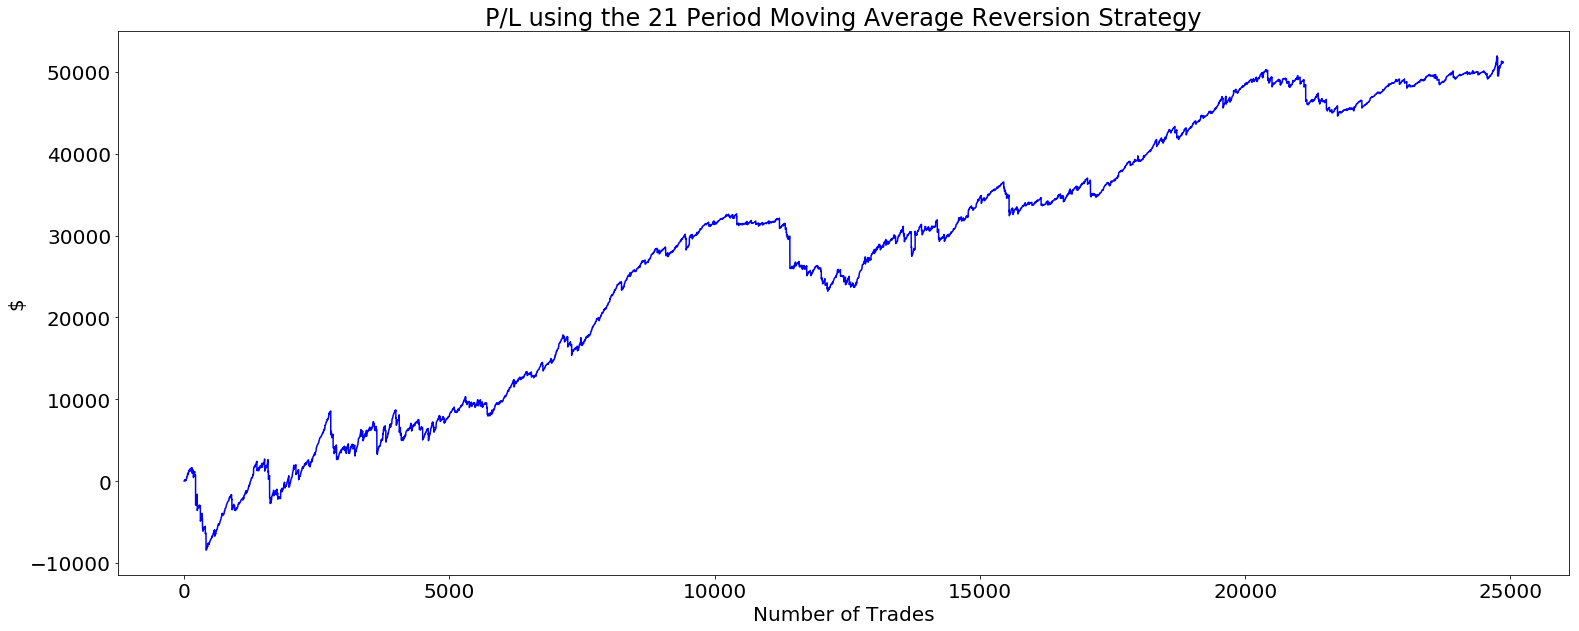

In [11]:
PL = pd.Series(np.cumsum(long21["P/L"]))


plt.figure(figsize=(26, 10), facecolor='w', edgecolor='k');
PL.plot(color='blue');
plt.title("P/L using the 21 Period Moving Average Reversion Strategy", loc='center', pad=None)
plt.ylabel("$");
plt.xlabel("Number of Trades");
plt.rcParams.update({'font.size': 20})

###### Investigation on the first and largest drawdown

In [12]:
PL[215:217]

215     745.9000
216   -2895.8200
Name: P/L, dtype: float64

In [13]:
long21.loc[215:420]

,Time,AveragePrice,Exit,TradeExecuted,size,pips,P/L,maxBuyDistance
215,2010-05-04 01:10:00,1.3202,1.3209,22,44000,6.7455,29.6800,-6.4000
216,2010-05-04 03:20:00,1.3067,1.2986,224,448000,-81.2884,-3641.7200,-78.5810
217,2010-05-04 22:50:00,1.2959,1.2962,36,72000,3.5056,25.2400,-32.7429
218,2010-05-05 02:10:00,1.2949,1.2961,14,28000,12.6143,35.3200,-15.0381
219,2010-05-05 03:25:00,1.2956,1.2965,5,10000,8.6800,8.6800,-7.6762
220,2010-05-05 05:45:00,1.2953,1.2982,17,34000,29.3294,99.7200,-22.9429
221,2010-05-05 07:30:00,1.2972,1.2978,1,2000,6.4000,1.2800,-1.8857
222,2010-05-05 08:40:00,1.2886,1.2870,61,122000,-15.4770,-188.8200,-140.6238
223,2010-05-05 15:40:00,1.2828,1.2827,51,102000,-1.1157,-11.3800,-68.8857
224,2010-05-05 20:00:00,1.2819,1.2822,2,4000,2.5000,1.0000,-3.5619


In [14]:
PLdrawdown = PL[0:1000]

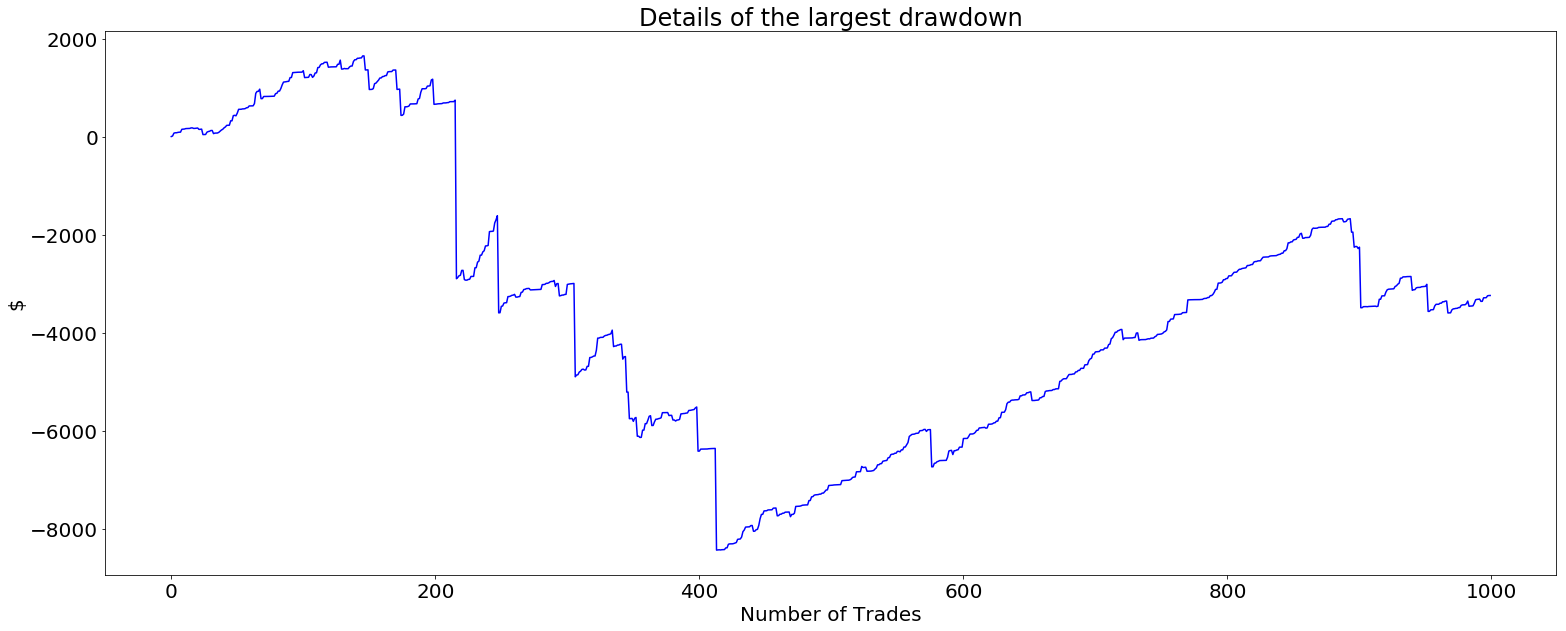

In [16]:
plt.figure(figsize=(26, 10), facecolor='w', edgecolor='k');
PLdrawdown.plot(color='blue');
plt.title("Details of the largest drawdown", loc='center', pad=None)
plt.ylabel("$");
plt.xlabel("Number of Trades");
plt.rcParams.update({'font.size': 20})

In [17]:
print("In the 10 year, there are " + str(long21.loc[np.where(long21["P/L"]<-1000)].shape[0]) + " long trades where the bot would have lost more than 1K")

In the 10 year, there are 39 long trades where the bot would have lost more than 1K


### Short Side

In [19]:
print("Short trades: " + str(len(sell21["maxSellDistance"])))
print("P/L: " + str(round(sell21["P/L"].sum(),2)))
print("Short win ratio: " + str(round(sell21.iloc[np.where(sell21["P/L"]>0)]["P/L"].count()/sell21.shape[0]*100, 1)) + "%")
print("Average short win: " + str(round(sell21.iloc[np.where(sell21["P/L"]>0)]["P/L"].mean(), 1)))
print("Average short loss: " + str(round(sell21.iloc[np.where(sell21["P/L"]<0)]["P/L"].mean(), 1)))
print("Average max distance from the 21 period MA: " + str(sell21["maxSellDistance"].mean()))

Short trades: 24856
P/L: 46090.6
Short win ratio: 92.8%
Average short win: 13.4
Average short loss: -152.5
Average max distance from the 21 period MA: 1.13812186771266


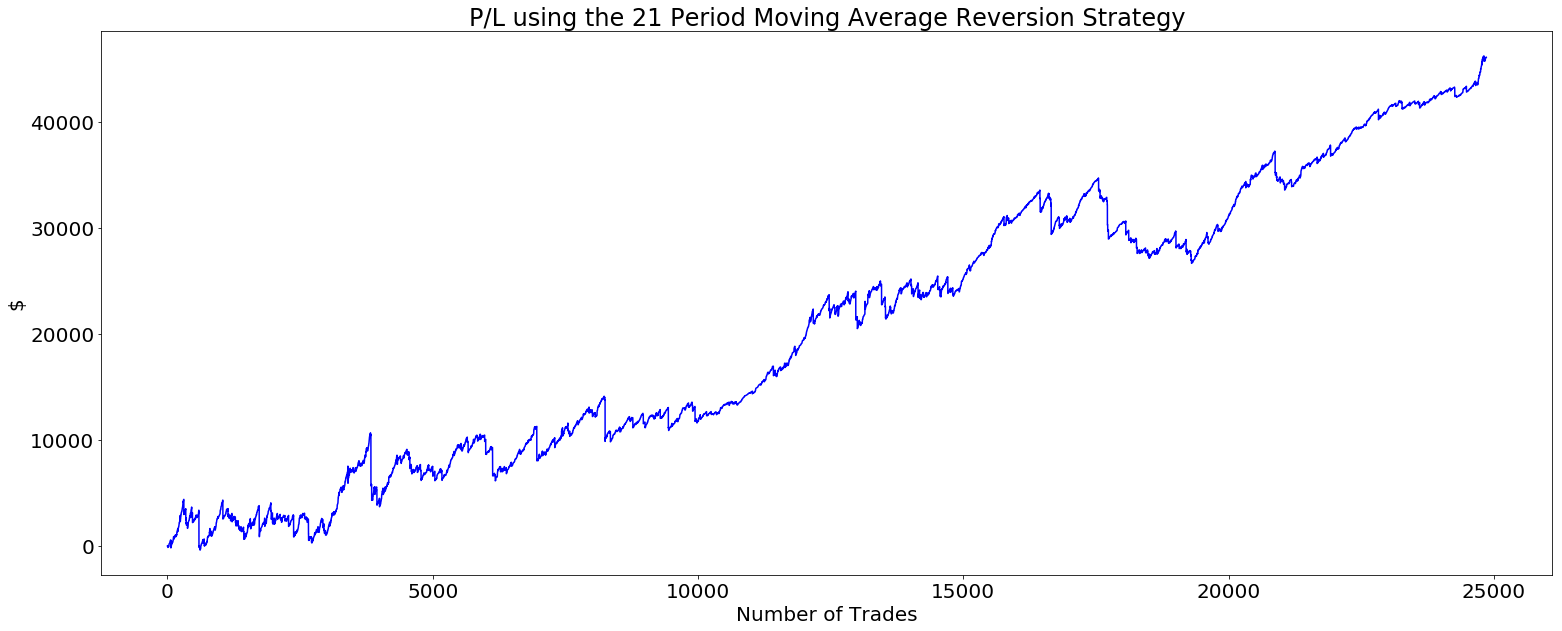

In [20]:
PL = pd.Series(np.cumsum(sell21["P/L"]))


plt.figure(figsize=(26, 10), facecolor='w', edgecolor='k');
PL.plot(color='blue');
plt.title("P/L using the 21 Period Moving Average Reversion Strategy", loc='center', pad=None)
plt.ylabel("$");
plt.xlabel("Number of Trades");
plt.rcParams.update({'font.size': 20})

## 61 Period Moving Average Reversion Strategy

In [36]:
#Export and Import the dataset
#eurusd.to_csv(os.getcwd()+'\\eurusd1min.csv')
eurusd = pd.read_csv(os.getcwd()+'\\eurusd1min.csv', index_col=0)

#Date.to_csv(os.getcwd()+'\\eurusd1minTime.csv')
Date = pd.read_csv(os.getcwd()+'\\eurusd1minTime.csv', header=None, index_col=0)
Date = Date.iloc[:,0]

In [37]:
print(eurusd.shape)
print(Date.shape)

(3485016, 5)
(3485016,)


In [38]:
slow_period, fastMA, slowMA = CrossMovingAverage(eurusd, 8, 61)

eurusd["fastMA"] = fastMA
eurusd["slowMA"] = slowMA

eurusd = eurusd.iloc[61:]
eurusd.index = range(eurusd.shape[0])

data = {'time':Date, 'close':eurusd["Close"],'fastMA':fastMA, 'slowMA':slowMA}

flag = pd.DataFrame(data)

flag.index = range(flag.shape[0])
flag = flag.drop(flag.index[0:61])
flag.index = range(flag.shape[0])

In [39]:
flag["distance"] = np.where(flag["close"] >= flag["slowMA"], (flag["close"]-flag["slowMA"])*10000, (flag["close"]-flag["slowMA"])*10000 )

In [42]:
flag["buyTrigger"] = 0
flag["buyWin"] = 0 
flag["sellTrigger"] = 0 
flag["sellWin"] = 0 

flag["buyTrigger"] = np.where(flag["distance"]<-0.01, 1,0)
flag["buyWin"] = np.where(flag["distance"]>0, 1,0)
flag["sellTrigger"] = np.where(flag["distance"]>0.01, 1,0)
flag["sellWin"] = np.where(flag["distance"]<0, 1,0)

flag.head(5)

,time,close,fastMA,slowMA,distance,buyTrigger,buyWin,sellTrigger,sellWin
0,2010-04-01 01:17:00,1.3501,1.3520,1.3539,-37.5869,1,0,0,1
1,2010-04-01 01:18:00,1.3498,1.3519,1.3538,-40.3623,1,0,0,1
2,2010-04-01 01:19:00,1.3499,1.3518,1.3538,-38.8787,1,0,0,1
3,2010-04-01 01:20:00,1.3500,1.3517,1.3537,-37.2656,1,0,0,1
4,2010-04-01 01:21:00,1.3501,1.3516,1.3537,-35.5770,1,0,0,1


In [43]:
flagBuy = flag.drop(["sellTrigger","sellWin"], axis=1)
flagSell = flag.drop(["buyTrigger","buyWin"], axis=1)

### Long

In [17]:
# I create a data frame with values of the maximum distance from the slow MA of every buy order
prev = 0
# the array splits shows me the indices where the column changes value
splits = np.append(np.where(np.diff(flagBuy["buyTrigger"]) != 0)[0],len(flagBuy["buyTrigger"]))
maxBuyDistance = []
count = []
averagePrice = []
exit = []
time = []

for split in splits[:-2]:
    
    indici = []
    
    # indici is a list of indices of rows that have consecutively the same value
    indici = np.arange(1,flagBuy["buyTrigger"].size,1)[prev:split]
    maxBuyDistance.append(min(flagBuy.loc[indici]["distance"]))
    count.append(len(indici))
    averagePrice.append(flagBuy.loc[indici]["close"].mean())
    exit.append(flagBuy.loc[split+1]["close"])
    time.append(flagBuy["time"].loc[prev])
    prev = split

In [21]:
data = {"Time": time, 'AveragePrice':averagePrice, 'Exit':exit, 'TradeExecuted':count, 'maxBuyDistance':maxBuyDistance}
long = pd.DataFrame(data=data, index=range(len(maxBuyDistance)))


long['pips'] = (long["Exit"] - long["AveragePrice"])*10000
long["size"] = long["TradeExecuted"]*2000
long["P/L"] = long["size"]*(long["Exit"] - long["AveragePrice"])

long=long[["Time", 'AveragePrice', 'Exit', 'TradeExecuted', "size", 'pips', "P/L", 'maxBuyDistance']]

long = long[::2]
long.index = range(long.shape[0])

long.head(5)

,Time,AveragePrice,Exit,TradeExecuted,size,pips,P/L,maxBuyDistance
0,2010-04-01 01:17:00,1.3504,1.3511,59,118000,7.0119,82.7400,-40.3623
1,2010-04-01 02:19:00,1.3503,1.3508,19,38000,5.1737,19.6600,-7.7672
2,2010-04-01 02:43:00,1.3505,1.3506,1,2000,1.1000,0.2200,-0.3508
3,2010-04-01 02:48:00,1.3503,1.3504,2,4000,0.9500,0.3800,-1.2033
4,2010-04-01 03:02:00,1.3502,1.3503,5,10000,1.5200,1.5200,-1.7705


### Short

In [44]:
# I create a data frame with values of the maximum distance from the slow MA of every sell order
prev = 0
# the array splits shows me the indices where the column changes value
splits = np.append(np.where(np.diff(flagSell["sellTrigger"]) != 0)[0],len(flagSell["sellTrigger"]))
maxSellDistance = []
count = []
averagePrice = []
exit = []
time = []

for split in splits[:-2]:
    
    indici = []
    
    # indici is a list of indices of rows that have consecutively the same value
    indici = np.arange(1,flagSell["sellTrigger"].size,1)[prev:split]
    maxSellDistance.append(min(flagSell.loc[indici]["distance"]))
    count.append(len(indici))
    averagePrice.append(flagSell.loc[indici]["close"].mean())
    exit.append(flagSell.loc[split+1]["close"])
    time.append(flagSell["time"].loc[prev])
    prev = split

In [48]:
data = {'Time':time, 'AveragePrice':averagePrice, 'Exit':exit, 'TradeExecuted':count, 'maxSellDistance':maxSellDistance}
sell = pd.DataFrame(data=data, index=range(len(maxSellDistance)))


sell['pips'] = (sell["AveragePrice"] - sell["Exit"])*10000
sell["size"] = sell["TradeExecuted"]*2000
sell["P/L"] = sell["size"]*(sell["AveragePrice"] - sell["Exit"])

sell=sell[['Time', 'AveragePrice', 'Exit', 'TradeExecuted', "size", 'pips', "P/L", 'maxSellDistance']]

sell = sell[1::2]
sell.index = range(sell.shape[0])

sell.head(5)

,AveragePrice,Exit,TradeExecuted,size,pips,P/L,maxSellDistance
0,1.3510,1.3509,3,6000,1.8667,1.1200,0.0721
1,1.3509,1.3505,5,10000,3.6400,3.6400,2.3098
2,1.3506,1.3503,4,8000,3.4250,2.7400,0.9410
3,1.3507,1.3502,11,22000,5.3727,11.8200,0.3361
4,1.3504,1.3502,3,6000,1.9000,1.1400,0.3492


## Stats: 61 Period Moving Average Reversion Strategy

In [2]:
#Export and Import the dataset
#eurusd.to_csv(os.getcwd()+'\\eurusd1min.csv')
eurusd = pd.read_csv(os.getcwd()+'\\eurusd1min.csv', index_col=0)

#Date.to_csv(os.getcwd()+'\\eurusd1minTime.csv')
Date = pd.read_csv(os.getcwd()+'\\eurusd1minTime.csv', header=None, index_col=0)
Date = Date.iloc[:,0]

#long.to_csv(os.getcwd()+'\\longEurusd1minMA.csv')
long61 = pd.read_csv(os.getcwd()+'\\longEurusd1min61MA.csv', index_col=0)

#sell.to_csv(os.getcwd()+'\\shortEurusd1min61MA.csv')
sell61 = pd.read_csv(os.getcwd()+'\\shortEurusd1min61MA.csv', index_col=0)

C:\Users\HP\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Long

In [4]:
print("Long trades: " + str(len(long61["maxBuyDistance"])))
print("P/L: " + str(round(long61["P/L"].sum(),2)))
print("Long win ratio: " + str(round(long61.iloc[np.where(long61["P/L"]>0)]["P/L"].count()/long61.shape[0]*100, 1)) + "%")
print("Average long win: " + str(round(long61.iloc[np.where(long61["P/L"]>0)]["P/L"].mean(), 1)))
print("Average long loss: " + str(round(long61.iloc[np.where(long61["P/L"]<0)]["P/L"].mean(), 1)))
print("Average max distance from the 61 period MA: " + str(long61["maxBuyDistance"].mean()))

Long trades: 65891
P/L: 231618.0
Long win ratio: 95.8%
Average long win: 17.8
Average long loss: -349.4
Average max distance from the 61 period MA: -5.8935752807135


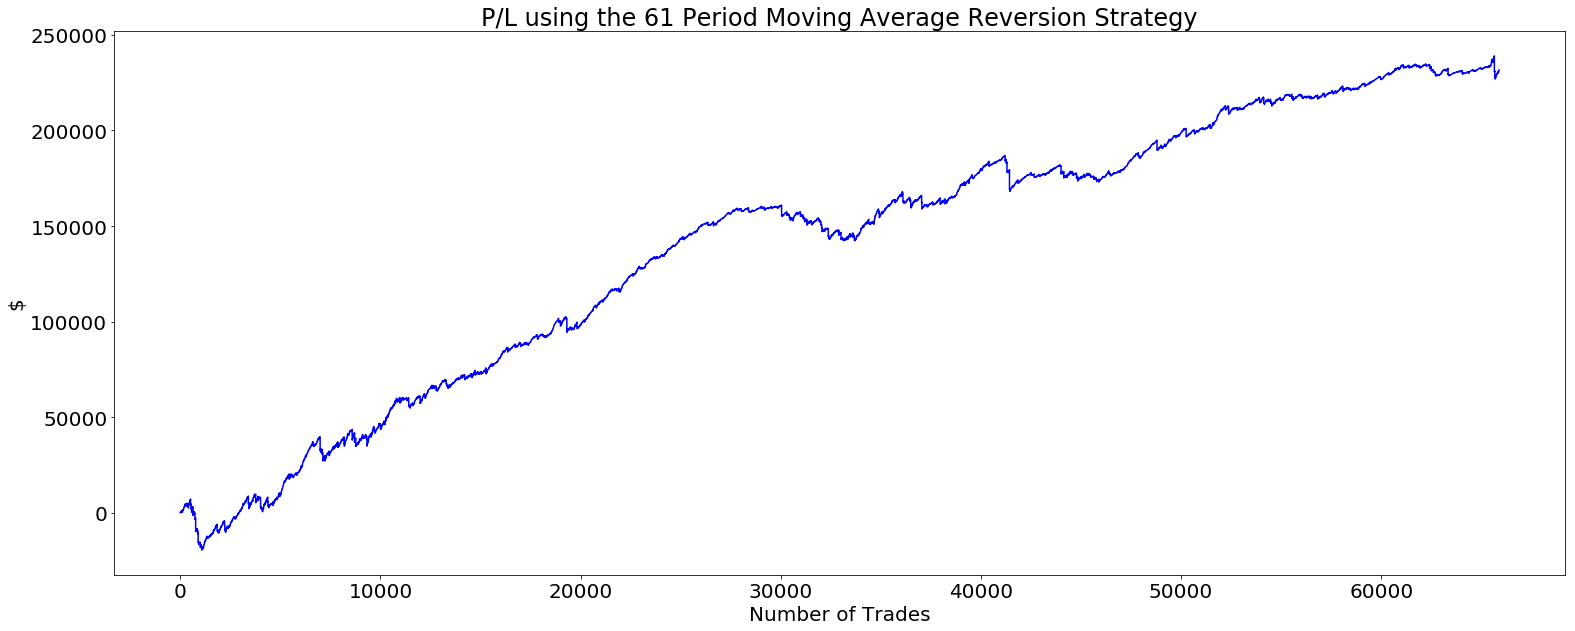

In [6]:
PL = pd.Series(np.cumsum(long61["P/L"]))


plt.figure(figsize=(26, 10), facecolor='w', edgecolor='k');
PL.plot(color='blue');
plt.title("P/L using the 61 Period Moving Average Reversion Strategy", loc='center', pad=None)
plt.ylabel("$");
plt.xlabel("Number of Trades");
plt.rcParams.update({'font.size': 20})

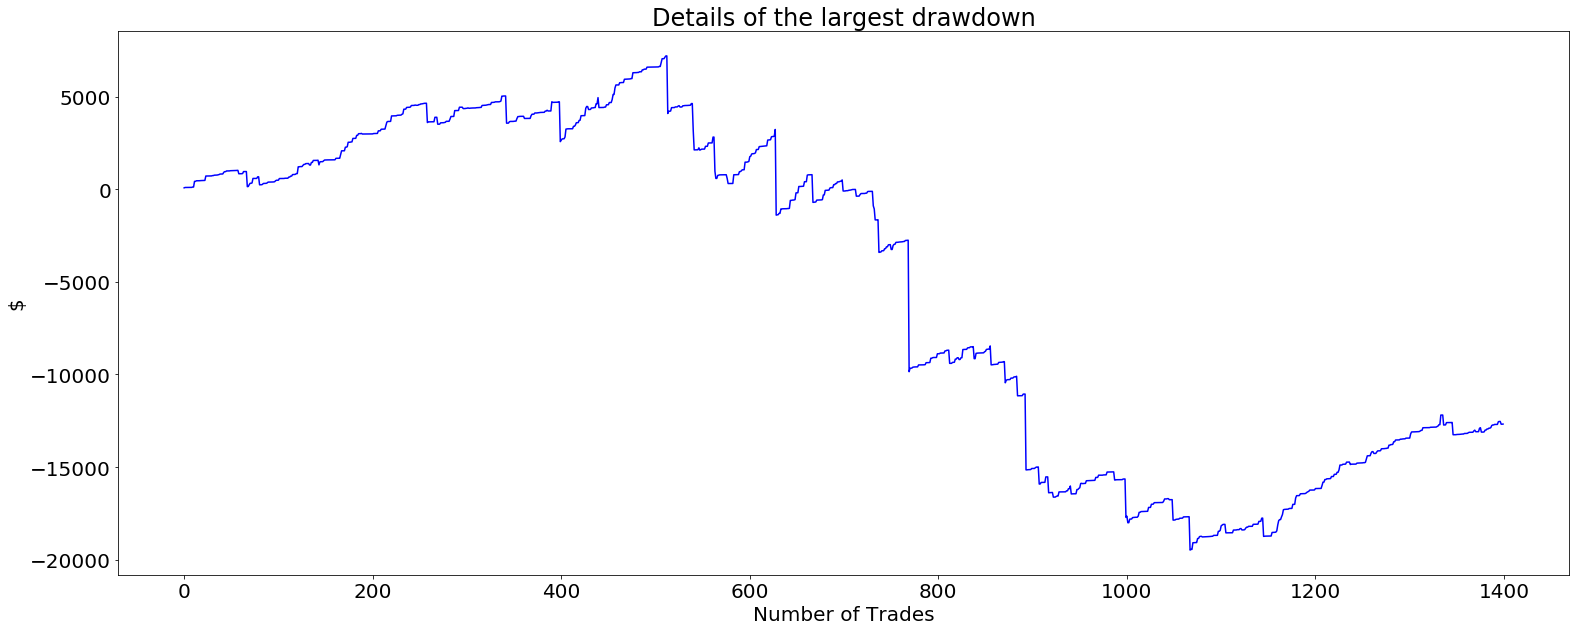

In [7]:
PLdrawdown = PL[0:1400]

plt.figure(figsize=(26, 10), facecolor='w', edgecolor='k');
PLdrawdown.plot(color='blue');
plt.title("Details of the largest drawdown", loc='center', pad=None)
plt.ylabel("$");
plt.xlabel("Number of Trades");
plt.rcParams.update({'font.size': 20})

### Short

In [7]:
print("Short trades: " + str(len(sell61["maxSellDistance"])))
print("P/L: " + str(round(sell61["P/L"].sum(),2)))
print("Short win ratio: " + str(round(sell61.iloc[np.where(sell61["P/L"]>0)]["P/L"].count()/sell61.shape[0]*100, 1)) + "%")
print("Average short win: " + str(round(sell61.iloc[np.where(sell61["P/L"]>0)]["P/L"].mean(), 1)))
print("Average short loss: " + str(round(sell61.iloc[np.where(sell61["P/L"]<0)]["P/L"].mean(), 1)))
print("Average max distance from the 21 period MA: " + str(sell61["maxSellDistance"].mean()))

Short trades: 65972
P/L: 205433.24
Short win ratio: 95.7%
Average short win: 17.8
Average short loss: -359.6
Average max distance from the 21 period MA: 0.5418416461558149


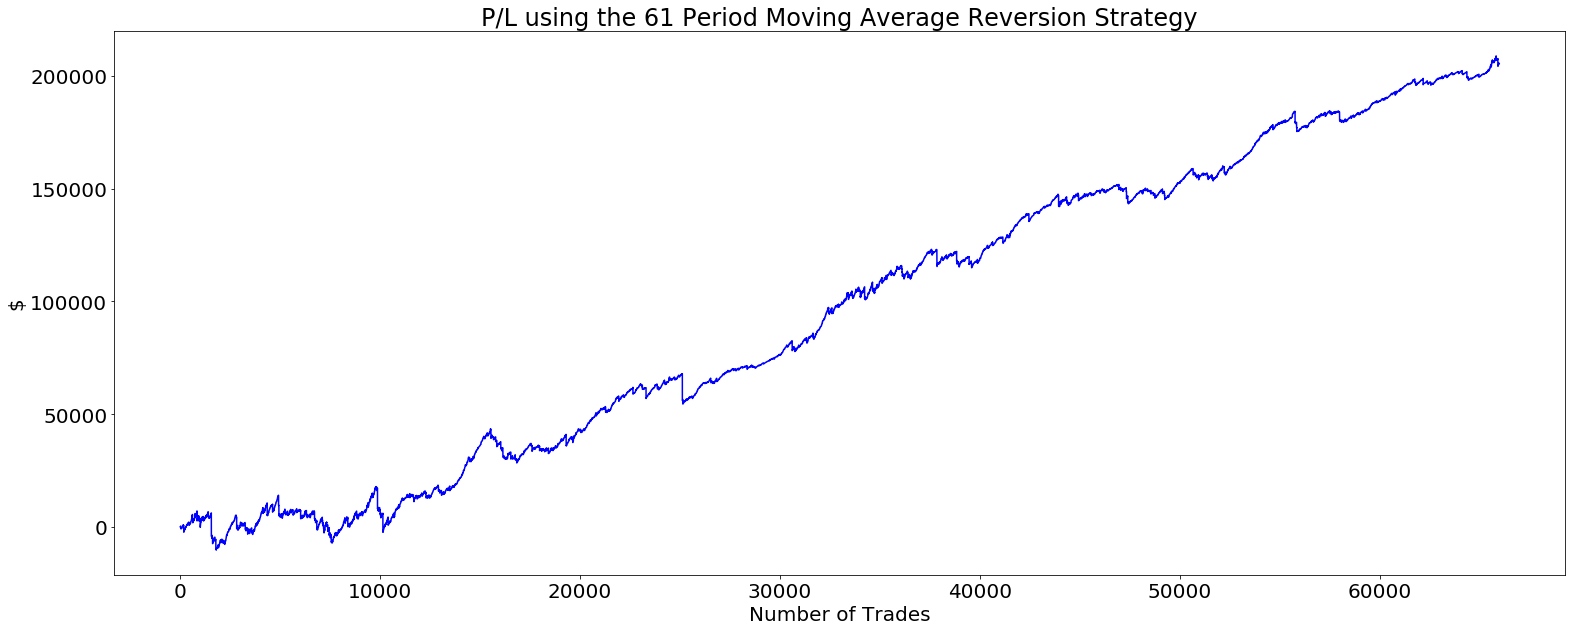

In [4]:
PL = pd.Series(np.cumsum(sell61["P/L"]))


plt.figure(figsize=(26, 10), facecolor='w', edgecolor='k');
PL.plot(color='blue');
plt.title("P/L using the 61 Period Moving Average Reversion Strategy", loc='center', pad=None)
plt.ylabel("$");
plt.xlabel("Number of Trades");
plt.rcParams.update({'font.size': 20})

## Comparison between 61 and 21 Moving Average Strategies

### Long

In [55]:
print("Number of Long trades using the 21 MA: " + str(len(long21["maxBuyDistance"])))
print("Number of Long trades using the 61 MA: " + str(len(long61["maxBuyDistance"])))

print("P/L of Long trades using the 21 MA: " + str(round(long21["P/L"].sum(),2)))
print("P/L of Long trades using the 61 MA: " + str(round(long61["P/L"].sum(),2)))

print("Long win ratio using the 21 MA: " + str(round(long21.iloc[np.where(long21["P/L"]>0)]["P/L"].count()/long21.shape[0]*100, 1)) + "%")
print("Long win ratio using the 61 MA: " + str(round(long61.iloc[np.where(long61["P/L"]>0)]["P/L"].count()/long61.shape[0]*100, 1)) + "%")

print("Average long win using the 21 MA: " + str(round(long21.iloc[np.where(long21["P/L"]>0)]["P/L"].mean(), 1)))
print("Average long win using the 61 MA: " + str(round(long61.iloc[np.where(long61["P/L"]>0)]["P/L"].mean(), 1)))

print("Average long loss using the 21 MA: " + str(round(long21.iloc[np.where(long21["P/L"]<0)]["P/L"].mean(), 1)))
print("Average long loss using the 61 MA: " + str(round(long61.iloc[np.where(long61["P/L"]<0)]["P/L"].mean(), 1)))

print("Average max distance from the 21 period MA: " + str(round(long21["maxBuyDistance"].mean(),2)))
print("Average max distance from the 61 period MA: " + str(round(long61["maxBuyDistance"].mean(),2)))

Number of Long trades using the 21 MA: 24863
Number of Long trades using the 61 MA: 65891
P/L of Long trades using the 21 MA: 51209.2
P/L of Long trades using the 61 MA: 231618.0
Long win ratio using the 21 MA: 92.9%
Long win ratio using the 61 MA: 95.8%
Average long win using the 21 MA: 14.0
Average long win using the 61 MA: 17.8
Average long loss using the 21 MA: -161.4
Average long loss using the 61 MA: -349.4
Average max distance from the 21 period MA: -10.53
Average max distance from the 61 period MA: -5.89


### Short

In [57]:
print("Number of Short trades using the 21 MA: " + str(len(sell21["maxSellDistance"])))
print("Number of Short trades using the 61 MA: " + str(len(sell61["maxSellDistance"])))

print("P/L of Short trades using the 21 MA: " + str(round(sell21["P/L"].sum(),2)))
print("P/L of Short trades using the 61 MA: " + str(round(sell61["P/L"].sum(),2)))

print("Short win ratio using the 21 MA: " + str(round(sell21.iloc[np.where(sell21["P/L"]>0)]["P/L"].count()/sell21.shape[0]*100, 1)) + "%")
print("Short win ratio using the 61 MA: " + str(round(sell61.iloc[np.where(sell61["P/L"]>0)]["P/L"].count()/sell61.shape[0]*100, 1)) + "%")

print("Average Short win using the 21 MA: " + str(round(sell21.iloc[np.where(sell21["P/L"]>0)]["P/L"].mean(), 1)))
print("Average Short win using the 61 MA: " + str(round(sell61.iloc[np.where(sell61["P/L"]>0)]["P/L"].mean(), 1)))

print("Average Short loss using the 21 MA: " + str(round(sell21.iloc[np.where(sell21["P/L"]<0)]["P/L"].mean(), 1)))
print("Average Short loss using the 61 MA: " + str(round(sell61.iloc[np.where(sell61["P/L"]<0)]["P/L"].mean(), 1)))

print("Average max distance from the 21 period MA: " + str(round(sell21["maxSellDistance"].mean(),2)))
print("Average max distance from the 61 period MA: " + str(round(sell61["maxSellDistance"].mean(),2)))

Number of Short trades using the 21 MA: 24856
Number of Short trades using the 61 MA: 65972
P/L of Short trades using the 21 MA: 46090.6
P/L of Short trades using the 61 MA: 205433.24
Short win ratio using the 21 MA: 92.8%
Short win ratio using the 61 MA: 95.7%
Average Short win using the 21 MA: 13.4
Average Short win using the 61 MA: 17.8
Average Short loss using the 21 MA: -152.5
Average Short loss using the 61 MA: -359.6
Average max distance from the 21 period MA: 1.14
Average max distance from the 61 period MA: 0.54
